In [1]:
import torch;
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import pandas as pd
import torchvision.models as models 
from torchvision import transforms, utils
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.optim import lr_scheduler
import seaborn as sns
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import copy
from tqdm import tqdm
#from model import VAE

import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from dataloader import *
from cnn_model import *

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
#only on validation set
csv_path = 'progress.csv'
img_path = '/home/vip/sayan-mandal/datasets/obj_criteria/good_reduced/'

CDL = CLUnivDataLoader(csv_path, img_path, transform = transforms.Compose([transforms.Resize(64),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),timestep=3,n=2)

#random sampler
batch_size = 64
validation_split = .2
test_split = .2
train_split = 1-validation_split-test_split
shuffle_dataset = True

# Creating data indices for training and validation splits:
dataset_size = len(CDL)
indices = list(range(dataset_size))
split_train = int(np.floor(train_split * dataset_size))
split_valid = int(np.floor((train_split+validation_split) * dataset_size))
if shuffle_dataset :
    np.random.shuffle(indices)
train_indices, val_indices, test_indices =  indices[:split_train],indices[split_train:split_valid],indices[split_valid:]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(CDL, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(CDL, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(CDL, batch_size=batch_size, sampler=test_sampler)

<AxesSubplot:xlabel='Slope ($\\mu$m/y)', ylabel='Count'>

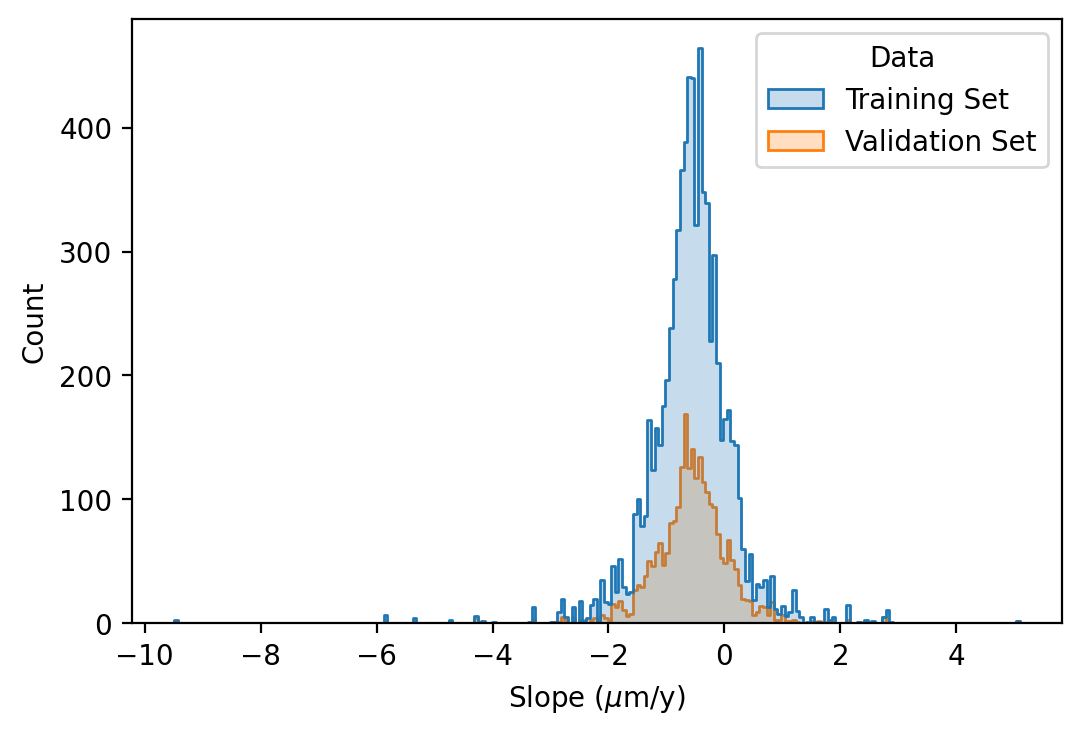

In [4]:

for batch_idx, (_, targets, _) in enumerate(train_loader):
    targets = Variable(targets.view(targets.shape[0],-1))

    if batch_idx == 0:
        true_scores = targets.cpu().numpy()
    else:
        true_scores = np.append(true_scores, targets.cpu().numpy(), axis = 0)

for batch_idx, (_, targets, _) in enumerate(valid_loader):
    targets = Variable(targets.view(targets.shape[0],-1))

    if batch_idx == 0:
        valtrue_scores = targets.cpu().numpy()
    else:
        valtrue_scores = np.append(valtrue_scores, targets.cpu().numpy(), axis = 0)

from scipy.stats import ks_2samp
dfx = pd.DataFrame.from_dict({'Slope ($\mu$m/y)': true_scores.ravel().tolist(), 'Data':'Training Set'})
dfy = pd.DataFrame.from_dict({'Slope ($\mu$m/y)': valtrue_scores.ravel().tolist(), 'Data':'Validation Set'})
df = pd.concat(axis=0, ignore_index=True, objs=[dfx,dfy])



fig,ax = plt.subplots()
sns.histplot(df,x='Slope ($\mu$m/y)',hue='Data',ax=ax, element='step')


In [5]:
print(len(true_scores), len(valtrue_scores))

7759 2586


In [6]:
torch.cuda.empty_cache()
tl = iter(train_loader)
dat,_,_ = next(tl)
bs, ts, C, H, W = dat.shape
n_out = 1
print(ts)

model = CNNLSTMNet(channels = C, ts = ts, n_out = n_out, device = device).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1)  #,momentum=0.9, nesterov=True)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[120], gamma= 0.1)
criterion = nn.MSELoss()  # this is for regression mean squared loss

3


In [7]:
epochs = 200
best_loss =float('inf')
ep, trainloss, validloss, testloss = [],[],[],[]
testep, totloss = [],[]
besttrloss, bestvalloss, besttsloss = 0,0,0
for epoch in range(1,epochs+1):
    model.train()
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
    trloss = 0
    for batch_idx, (data, targets, _) in loop:
        optimizer.zero_grad() 
        data = Variable(data).to(device)
        targets = Variable(targets.to(torch.float).view(targets.shape[0],-1)).to(device)

        #forward pass
        scores = model(data)
        loss = criterion(scores, targets)
        trloss += loss.item()
        #backward pass   
        loss.backward()

        #gradient descent
        optimizer.step()
        loop.set_description(f"Epoch [{epoch}/{epochs}]")
        loop.set_postfix(batch_loss = loss.item(), running_loss = trloss )
    scheduler.step()

    model.eval()
    valloss = 0
    with torch.no_grad():
        for data, targets, _ in valid_loader:
            data = Variable(data).to(device)
            targets = Variable(targets.to(torch.float).view(targets.shape[0],-1)).to(device)

            
            scores = model(data)
            loss = criterion(scores, targets)

            valloss += loss.item()

    if valloss < best_loss:
        tsloss = 0
        with torch.no_grad():
            for data, targets, _ in test_loader:
                data = Variable(data).to(device)
                targets = Variable(targets.to(torch.float).view(targets.shape[0],-1)).to(device)

                
                scores = model(data)
                loss = criterion(scores, targets)

                tsloss += loss.item()
            testloss += [tsloss]
            testep += [epoch]
        to_print = "Train Loss: {:.4f} | Valid Loss: {:.4f} ===========> {:.4f} | Test Loss: {:.4f} | Saving model...".format(trloss, best_loss, valloss, tsloss)
        best_loss = valloss
        bestvalloss = valloss
        besttrloss = trloss
        besttsloss = tsloss
        best_e = epoch
        torch.save(model.state_dict(),'state_cnn_ts3_2.pt')
        #best_model = copy.deepcopy(model)
    else:
        to_print = "Train Loss: {:.4f} | Valid Loss: {:.4f}".format(trloss, valloss)

    print(to_print)
    ep+=[epoch]
    trainloss += [trloss]
    validloss += [valloss]
    totloss += [trloss + valloss]

Epoch [1/200]: 100%|██████████| 122/122 [00:21<00:00,  5.60it/s, batch_loss=0.313, running_loss=65.8]


Train Loss: 65.7779 | Valid Loss: inf ===========> 21.5075 | Test Loss: 20.9016 | Saving model...


Epoch [2/200]: 100%|██████████| 122/122 [00:21<00:00,  5.59it/s, batch_loss=0.334, running_loss=64.8]


Train Loss: 64.8275 | Valid Loss: 21.6531


Epoch [3/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.257, running_loss=63.9]


Train Loss: 63.9050 | Valid Loss: 21.5374


Epoch [4/200]: 100%|██████████| 122/122 [00:21<00:00,  5.63it/s, batch_loss=1.46, running_loss=64.2]


Train Loss: 64.2137 | Valid Loss: 21.5075 ===========> 21.1267 | Test Loss: 20.6841 | Saving model...


Epoch [5/200]: 100%|██████████| 122/122 [00:21<00:00,  5.61it/s, batch_loss=0.0937, running_loss=62.3]


Train Loss: 62.2798 | Valid Loss: 21.1267 ===========> 21.0523 | Test Loss: 20.6114 | Saving model...


Epoch [6/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.415, running_loss=60.7]


Train Loss: 60.7359 | Valid Loss: 21.8172


Epoch [7/200]: 100%|██████████| 122/122 [00:21<00:00,  5.61it/s, batch_loss=0.224, running_loss=59.1]


Train Loss: 59.1198 | Valid Loss: 21.4144


Epoch [8/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.183, running_loss=56.3]


Train Loss: 56.2574 | Valid Loss: 21.0523 ===========> 20.0859 | Test Loss: 20.0397 | Saving model...


Epoch [9/200]: 100%|██████████| 122/122 [00:21<00:00,  5.63it/s, batch_loss=1.4, running_loss=55.4]


Train Loss: 55.4465 | Valid Loss: 60.2892


Epoch [10/200]: 100%|██████████| 122/122 [00:21<00:00,  5.61it/s, batch_loss=0.384, running_loss=55.4]


Train Loss: 55.4118 | Valid Loss: 20.0859 ===========> 20.0616 | Test Loss: 19.6858 | Saving model...


Epoch [11/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.188, running_loss=49.7]


Train Loss: 49.7207 | Valid Loss: 20.0616 ===========> 19.3379 | Test Loss: 19.2184 | Saving model...


Epoch [12/200]: 100%|██████████| 122/122 [00:21<00:00,  5.63it/s, batch_loss=0.635, running_loss=47]


Train Loss: 47.0487 | Valid Loss: 21.5759


Epoch [13/200]: 100%|██████████| 122/122 [00:21<00:00,  5.61it/s, batch_loss=0.927, running_loss=43.5]


Train Loss: 43.4860 | Valid Loss: 32.4863


Epoch [14/200]: 100%|██████████| 122/122 [00:21<00:00,  5.60it/s, batch_loss=0.282, running_loss=40.6]


Train Loss: 40.5834 | Valid Loss: 20.0329


Epoch [15/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.213, running_loss=36.7]


Train Loss: 36.6790 | Valid Loss: 19.3379 ===========> 18.5406 | Test Loss: 18.8010 | Saving model...


Epoch [16/200]: 100%|██████████| 122/122 [00:21<00:00,  5.61it/s, batch_loss=0.122, running_loss=32.9]


Train Loss: 32.8729 | Valid Loss: 18.5406 ===========> 17.1951 | Test Loss: 17.4760 | Saving model...


Epoch [17/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.328, running_loss=29.1]


Train Loss: 29.1314 | Valid Loss: 19.1542


Epoch [18/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.268, running_loss=25.9]


Train Loss: 25.9161 | Valid Loss: 22.1894


Epoch [19/200]: 100%|██████████| 122/122 [00:21<00:00,  5.60it/s, batch_loss=0.0859, running_loss=23.4]


Train Loss: 23.4171 | Valid Loss: 19.4055


Epoch [20/200]: 100%|██████████| 122/122 [00:21<00:00,  5.64it/s, batch_loss=0.192, running_loss=18.6]


Train Loss: 18.6025 | Valid Loss: 25.0210


Epoch [21/200]: 100%|██████████| 122/122 [00:21<00:00,  5.64it/s, batch_loss=0.0864, running_loss=18.4]


Train Loss: 18.4373 | Valid Loss: 17.1951 ===========> 15.7582 | Test Loss: 16.0850 | Saving model...


Epoch [22/200]: 100%|██████████| 122/122 [00:21<00:00,  5.61it/s, batch_loss=0.288, running_loss=14.5]


Train Loss: 14.5161 | Valid Loss: 17.0073


Epoch [23/200]: 100%|██████████| 122/122 [00:21<00:00,  5.61it/s, batch_loss=0.103, running_loss=13.5]


Train Loss: 13.4566 | Valid Loss: 16.0135


Epoch [24/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.0733, running_loss=11.3]


Train Loss: 11.2974 | Valid Loss: 15.7582 ===========> 14.5485 | Test Loss: 15.1891 | Saving model...


Epoch [25/200]: 100%|██████████| 122/122 [00:21<00:00,  5.59it/s, batch_loss=0.0458, running_loss=10]


Train Loss: 10.0375 | Valid Loss: 15.9193


Epoch [26/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.0921, running_loss=9.2]


Train Loss: 9.2031 | Valid Loss: 15.9465


Epoch [27/200]: 100%|██████████| 122/122 [00:21<00:00,  5.63it/s, batch_loss=0.0224, running_loss=7.46]


Train Loss: 7.4627 | Valid Loss: 14.5485 ===========> 13.4869 | Test Loss: 14.7466 | Saving model...


Epoch [28/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.0715, running_loss=7.19]


Train Loss: 7.1855 | Valid Loss: 13.8395


Epoch [29/200]: 100%|██████████| 122/122 [00:21<00:00,  5.63it/s, batch_loss=0.0683, running_loss=6.98]


Train Loss: 6.9794 | Valid Loss: 15.1185


Epoch [30/200]: 100%|██████████| 122/122 [00:21<00:00,  5.63it/s, batch_loss=0.0348, running_loss=6.67]


Train Loss: 6.6723 | Valid Loss: 14.9159


Epoch [31/200]: 100%|██████████| 122/122 [00:21<00:00,  5.61it/s, batch_loss=0.0391, running_loss=5.37]


Train Loss: 5.3690 | Valid Loss: 13.4869 ===========> 13.4295 | Test Loss: 14.5648 | Saving model...


Epoch [32/200]: 100%|██████████| 122/122 [00:21<00:00,  5.61it/s, batch_loss=0.0409, running_loss=4.98]


Train Loss: 4.9769 | Valid Loss: 13.4295 ===========> 13.3093 | Test Loss: 14.3628 | Saving model...


Epoch [33/200]: 100%|██████████| 122/122 [00:21<00:00,  5.61it/s, batch_loss=0.0908, running_loss=5.23]


Train Loss: 5.2347 | Valid Loss: 13.4168


Epoch [34/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.0318, running_loss=4.95]


Train Loss: 4.9543 | Valid Loss: 13.3093 ===========> 13.2509 | Test Loss: 14.1887 | Saving model...


Epoch [35/200]: 100%|██████████| 122/122 [00:21<00:00,  5.60it/s, batch_loss=0.0239, running_loss=4.66]


Train Loss: 4.6592 | Valid Loss: 13.2509 ===========> 13.1721 | Test Loss: 14.1977 | Saving model...


Epoch [36/200]: 100%|██████████| 122/122 [00:21<00:00,  5.61it/s, batch_loss=0.0215, running_loss=4.21]


Train Loss: 4.2085 | Valid Loss: 13.1721 ===========> 12.7703 | Test Loss: 14.0673 | Saving model...


Epoch [37/200]: 100%|██████████| 122/122 [00:21<00:00,  5.60it/s, batch_loss=0.07, running_loss=3.81]


Train Loss: 3.8119 | Valid Loss: 17.4036


Epoch [38/200]: 100%|██████████| 122/122 [00:21<00:00,  5.61it/s, batch_loss=0.0221, running_loss=3.8]


Train Loss: 3.8011 | Valid Loss: 13.2103


Epoch [39/200]: 100%|██████████| 122/122 [00:21<00:00,  5.61it/s, batch_loss=0.0266, running_loss=3.55]


Train Loss: 3.5457 | Valid Loss: 13.2546


Epoch [40/200]: 100%|██████████| 122/122 [00:21<00:00,  5.66it/s, batch_loss=0.0183, running_loss=3.4]


Train Loss: 3.3966 | Valid Loss: 12.7703 ===========> 12.6800 | Test Loss: 13.7655 | Saving model...


Epoch [41/200]: 100%|██████████| 122/122 [00:21<00:00,  5.64it/s, batch_loss=0.0191, running_loss=3.2]


Train Loss: 3.2000 | Valid Loss: 12.6800 ===========> 12.4979 | Test Loss: 14.3532 | Saving model...


Epoch [42/200]: 100%|██████████| 122/122 [00:21<00:00,  5.61it/s, batch_loss=0.0242, running_loss=3.08]


Train Loss: 3.0807 | Valid Loss: 12.6747


Epoch [43/200]: 100%|██████████| 122/122 [00:21<00:00,  5.61it/s, batch_loss=0.0295, running_loss=3.2]


Train Loss: 3.2007 | Valid Loss: 13.0857


Epoch [44/200]: 100%|██████████| 122/122 [00:21<00:00,  5.60it/s, batch_loss=0.0163, running_loss=3.15]


Train Loss: 3.1542 | Valid Loss: 12.4979 ===========> 12.4345 | Test Loss: 13.5501 | Saving model...


Epoch [45/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.0523, running_loss=2.91]


Train Loss: 2.9064 | Valid Loss: 13.6754


Epoch [46/200]: 100%|██████████| 122/122 [00:21<00:00,  5.63it/s, batch_loss=0.0439, running_loss=3.03]


Train Loss: 3.0275 | Valid Loss: 12.4345 ===========> 12.4152 | Test Loss: 13.5721 | Saving model...


Epoch [47/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.0245, running_loss=2.98]


Train Loss: 2.9813 | Valid Loss: 12.4152 ===========> 12.1081 | Test Loss: 13.5029 | Saving model...


Epoch [48/200]: 100%|██████████| 122/122 [00:21<00:00,  5.61it/s, batch_loss=0.0377, running_loss=3.06]


Train Loss: 3.0585 | Valid Loss: 13.0167


Epoch [49/200]: 100%|██████████| 122/122 [00:21<00:00,  5.61it/s, batch_loss=0.0125, running_loss=2.74]


Train Loss: 2.7447 | Valid Loss: 12.4985


Epoch [50/200]: 100%|██████████| 122/122 [00:21<00:00,  5.63it/s, batch_loss=0.0476, running_loss=2.83]


Train Loss: 2.8267 | Valid Loss: 12.6266


Epoch [51/200]: 100%|██████████| 122/122 [00:21<00:00,  5.63it/s, batch_loss=0.0349, running_loss=2.58]


Train Loss: 2.5844 | Valid Loss: 12.3021


Epoch [52/200]: 100%|██████████| 122/122 [00:21<00:00,  5.63it/s, batch_loss=0.043, running_loss=2.54]


Train Loss: 2.5362 | Valid Loss: 13.6872


Epoch [53/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.0162, running_loss=2.54]


Train Loss: 2.5416 | Valid Loss: 12.2193


Epoch [54/200]: 100%|██████████| 122/122 [00:21<00:00,  5.63it/s, batch_loss=0.0393, running_loss=2.35]


Train Loss: 2.3548 | Valid Loss: 12.8508


Epoch [55/200]: 100%|██████████| 122/122 [00:21<00:00,  5.61it/s, batch_loss=0.0121, running_loss=2.33]


Train Loss: 2.3341 | Valid Loss: 12.2463


Epoch [56/200]: 100%|██████████| 122/122 [00:21<00:00,  5.63it/s, batch_loss=0.036, running_loss=2.38]


Train Loss: 2.3799 | Valid Loss: 12.1081 ===========> 11.9899 | Test Loss: 13.2567 | Saving model...


Epoch [57/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.0225, running_loss=2.33]


Train Loss: 2.3285 | Valid Loss: 12.1608


Epoch [58/200]: 100%|██████████| 122/122 [00:21<00:00,  5.64it/s, batch_loss=0.0487, running_loss=2.21]


Train Loss: 2.2050 | Valid Loss: 12.3133


Epoch [59/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.0242, running_loss=2.18]


Train Loss: 2.1841 | Valid Loss: 13.5850


Epoch [60/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.0114, running_loss=2.34]


Train Loss: 2.3434 | Valid Loss: 12.3701


Epoch [61/200]: 100%|██████████| 122/122 [00:21<00:00,  5.61it/s, batch_loss=0.0218, running_loss=2.13]


Train Loss: 2.1280 | Valid Loss: 12.5920


Epoch [62/200]: 100%|██████████| 122/122 [00:21<00:00,  5.61it/s, batch_loss=0.0135, running_loss=2.04]


Train Loss: 2.0385 | Valid Loss: 12.2677


Epoch [63/200]: 100%|██████████| 122/122 [00:21<00:00,  5.61it/s, batch_loss=0.0127, running_loss=1.92]


Train Loss: 1.9159 | Valid Loss: 12.3562


Epoch [64/200]: 100%|██████████| 122/122 [00:21<00:00,  5.63it/s, batch_loss=0.041, running_loss=1.96]


Train Loss: 1.9607 | Valid Loss: 12.5247


Epoch [65/200]: 100%|██████████| 122/122 [00:21<00:00,  5.64it/s, batch_loss=0.0276, running_loss=1.91]


Train Loss: 1.9104 | Valid Loss: 12.3373


Epoch [66/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.0256, running_loss=1.98]


Train Loss: 1.9750 | Valid Loss: 12.6813


Epoch [67/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.0269, running_loss=1.96]


Train Loss: 1.9561 | Valid Loss: 11.9899 ===========> 11.9642 | Test Loss: 13.0038 | Saving model...


Epoch [68/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.011, running_loss=1.93]


Train Loss: 1.9297 | Valid Loss: 11.9642 ===========> 11.6222 | Test Loss: 12.7667 | Saving model...


Epoch [69/200]: 100%|██████████| 122/122 [00:21<00:00,  5.63it/s, batch_loss=0.0231, running_loss=1.91]


Train Loss: 1.9054 | Valid Loss: 12.0062


Epoch [70/200]: 100%|██████████| 122/122 [00:21<00:00,  5.64it/s, batch_loss=0.0109, running_loss=1.78]


Train Loss: 1.7839 | Valid Loss: 11.9680


Epoch [71/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.00631, running_loss=1.76]


Train Loss: 1.7597 | Valid Loss: 12.0572


Epoch [72/200]: 100%|██████████| 122/122 [00:21<00:00,  5.61it/s, batch_loss=0.0147, running_loss=1.72]


Train Loss: 1.7240 | Valid Loss: 11.9147


Epoch [73/200]: 100%|██████████| 122/122 [00:21<00:00,  5.61it/s, batch_loss=0.0174, running_loss=1.79]


Train Loss: 1.7919 | Valid Loss: 12.0011


Epoch [74/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.00464, running_loss=1.76]


Train Loss: 1.7637 | Valid Loss: 11.9607


Epoch [75/200]: 100%|██████████| 122/122 [00:21<00:00,  5.61it/s, batch_loss=0.016, running_loss=1.74]


Train Loss: 1.7401 | Valid Loss: 12.0660


Epoch [76/200]: 100%|██████████| 122/122 [00:21<00:00,  5.61it/s, batch_loss=0.00627, running_loss=1.71]


Train Loss: 1.7106 | Valid Loss: 11.9859


Epoch [77/200]: 100%|██████████| 122/122 [00:21<00:00,  5.61it/s, batch_loss=0.00669, running_loss=1.68]


Train Loss: 1.6821 | Valid Loss: 11.8484


Epoch [78/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.0209, running_loss=1.67]


Train Loss: 1.6738 | Valid Loss: 12.2474


Epoch [79/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.00678, running_loss=1.64]


Train Loss: 1.6357 | Valid Loss: 11.8191


Epoch [80/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.0247, running_loss=1.65]


Train Loss: 1.6487 | Valid Loss: 11.9919


Epoch [81/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.018, running_loss=1.67]


Train Loss: 1.6743 | Valid Loss: 11.9118


Epoch [82/200]: 100%|██████████| 122/122 [00:21<00:00,  5.63it/s, batch_loss=0.00601, running_loss=1.57]


Train Loss: 1.5747 | Valid Loss: 12.0358


Epoch [83/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.0276, running_loss=1.61]


Train Loss: 1.6115 | Valid Loss: 11.8498


Epoch [84/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.015, running_loss=1.52]


Train Loss: 1.5203 | Valid Loss: 11.8700


Epoch [85/200]: 100%|██████████| 122/122 [00:21<00:00,  5.63it/s, batch_loss=0.0234, running_loss=1.53]


Train Loss: 1.5294 | Valid Loss: 12.4199


Epoch [86/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.00949, running_loss=1.52]


Train Loss: 1.5224 | Valid Loss: 11.7705


Epoch [87/200]: 100%|██████████| 122/122 [00:21<00:00,  5.63it/s, batch_loss=0.0252, running_loss=1.55]


Train Loss: 1.5481 | Valid Loss: 11.8944


Epoch [88/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.00607, running_loss=1.51]


Train Loss: 1.5098 | Valid Loss: 12.5926


Epoch [89/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.00852, running_loss=1.42]


Train Loss: 1.4190 | Valid Loss: 11.7421


Epoch [90/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.0184, running_loss=1.46]


Train Loss: 1.4569 | Valid Loss: 11.6222 ===========> 11.5051 | Test Loss: 12.5990 | Saving model...


Epoch [91/200]: 100%|██████████| 122/122 [00:21<00:00,  5.61it/s, batch_loss=0.00949, running_loss=1.52]


Train Loss: 1.5233 | Valid Loss: 11.7027


Epoch [92/200]: 100%|██████████| 122/122 [00:21<00:00,  5.64it/s, batch_loss=0.0115, running_loss=1.41]


Train Loss: 1.4079 | Valid Loss: 11.6528


Epoch [93/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.0169, running_loss=1.44]


Train Loss: 1.4363 | Valid Loss: 12.3386


Epoch [94/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.0185, running_loss=1.48]


Train Loss: 1.4830 | Valid Loss: 11.7335


Epoch [95/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.0134, running_loss=1.4]


Train Loss: 1.4017 | Valid Loss: 11.8036


Epoch [96/200]: 100%|██████████| 122/122 [00:21<00:00,  5.60it/s, batch_loss=0.0169, running_loss=1.41]


Train Loss: 1.4089 | Valid Loss: 12.1194


Epoch [97/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.00595, running_loss=1.36]


Train Loss: 1.3567 | Valid Loss: 11.6479


Epoch [98/200]: 100%|██████████| 122/122 [00:21<00:00,  5.64it/s, batch_loss=0.00532, running_loss=1.35]


Train Loss: 1.3502 | Valid Loss: 11.5366


Epoch [99/200]: 100%|██████████| 122/122 [00:21<00:00,  5.61it/s, batch_loss=0.00933, running_loss=1.31]


Train Loss: 1.3063 | Valid Loss: 11.6603


Epoch [100/200]: 100%|██████████| 122/122 [00:21<00:00,  5.63it/s, batch_loss=0.0154, running_loss=1.27]


Train Loss: 1.2697 | Valid Loss: 11.5051 ===========> 11.2429 | Test Loss: 12.4294 | Saving model...


Epoch [101/200]: 100%|██████████| 122/122 [00:21<00:00,  5.63it/s, batch_loss=0.0224, running_loss=1.32]


Train Loss: 1.3169 | Valid Loss: 12.3287


Epoch [102/200]: 100%|██████████| 122/122 [00:21<00:00,  5.63it/s, batch_loss=0.00958, running_loss=1.34]


Train Loss: 1.3406 | Valid Loss: 11.9893


Epoch [103/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.01, running_loss=1.33]


Train Loss: 1.3318 | Valid Loss: 11.6234


Epoch [104/200]: 100%|██████████| 122/122 [00:21<00:00,  5.65it/s, batch_loss=0.00607, running_loss=1.3]


Train Loss: 1.3000 | Valid Loss: 11.5735


Epoch [105/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.0105, running_loss=1.3]


Train Loss: 1.3000 | Valid Loss: 11.7373


Epoch [106/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.00837, running_loss=1.26]


Train Loss: 1.2605 | Valid Loss: 11.8645


Epoch [107/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.0075, running_loss=1.26]


Train Loss: 1.2556 | Valid Loss: 11.6125


Epoch [108/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.0179, running_loss=1.27]


Train Loss: 1.2701 | Valid Loss: 11.6641


Epoch [109/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.0233, running_loss=1.28]


Train Loss: 1.2826 | Valid Loss: 11.5748


Epoch [110/200]: 100%|██████████| 122/122 [00:21<00:00,  5.63it/s, batch_loss=0.0197, running_loss=1.22]


Train Loss: 1.2172 | Valid Loss: 11.5492


Epoch [111/200]: 100%|██████████| 122/122 [00:21<00:00,  5.64it/s, batch_loss=0.0123, running_loss=1.21]


Train Loss: 1.2090 | Valid Loss: 11.9497


Epoch [112/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.00739, running_loss=1.34]


Train Loss: 1.3395 | Valid Loss: 11.7552


Epoch [113/200]: 100%|██████████| 122/122 [00:21<00:00,  5.61it/s, batch_loss=0.0151, running_loss=1.25]


Train Loss: 1.2460 | Valid Loss: 11.5934


Epoch [114/200]: 100%|██████████| 122/122 [00:21<00:00,  5.63it/s, batch_loss=0.0106, running_loss=1.23]


Train Loss: 1.2267 | Valid Loss: 11.3808


Epoch [115/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.0114, running_loss=1.19]


Train Loss: 1.1917 | Valid Loss: 11.8322


Epoch [116/200]: 100%|██████████| 122/122 [00:21<00:00,  5.63it/s, batch_loss=0.0108, running_loss=1.28]


Train Loss: 1.2755 | Valid Loss: 11.4850


Epoch [117/200]: 100%|██████████| 122/122 [00:21<00:00,  5.61it/s, batch_loss=0.00514, running_loss=1.21]


Train Loss: 1.2112 | Valid Loss: 11.8919


Epoch [118/200]: 100%|██████████| 122/122 [00:21<00:00,  5.63it/s, batch_loss=0.0107, running_loss=1.19]


Train Loss: 1.1949 | Valid Loss: 11.4172


Epoch [119/200]: 100%|██████████| 122/122 [00:21<00:00,  5.63it/s, batch_loss=0.0083, running_loss=1.15]


Train Loss: 1.1523 | Valid Loss: 11.5376


Epoch [120/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.00665, running_loss=1.14]


Train Loss: 1.1440 | Valid Loss: 11.5522


Epoch [121/200]: 100%|██████████| 122/122 [00:21<00:00,  5.61it/s, batch_loss=0.0131, running_loss=1.11]


Train Loss: 1.1089 | Valid Loss: 11.8816


Epoch [122/200]: 100%|██████████| 122/122 [00:21<00:00,  5.61it/s, batch_loss=0.00658, running_loss=1.07]


Train Loss: 1.0747 | Valid Loss: 11.5570


Epoch [123/200]: 100%|██████████| 122/122 [00:21<00:00,  5.64it/s, batch_loss=0.0249, running_loss=1.1]


Train Loss: 1.0995 | Valid Loss: 11.4681


Epoch [124/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.00999, running_loss=1.05]


Train Loss: 1.0543 | Valid Loss: 11.5766


Epoch [125/200]: 100%|██████████| 122/122 [00:21<00:00,  5.65it/s, batch_loss=0.00562, running_loss=1.03]


Train Loss: 1.0349 | Valid Loss: 11.4334


Epoch [126/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.0717, running_loss=1.11]


Train Loss: 1.1067 | Valid Loss: 11.6150


Epoch [127/200]: 100%|██████████| 122/122 [00:21<00:00,  5.61it/s, batch_loss=0.00438, running_loss=1.04]


Train Loss: 1.0375 | Valid Loss: 11.4906


Epoch [128/200]: 100%|██████████| 122/122 [00:21<00:00,  5.63it/s, batch_loss=0.0238, running_loss=0.987]


Train Loss: 0.9870 | Valid Loss: 11.5013


Epoch [129/200]: 100%|██████████| 122/122 [00:21<00:00,  5.63it/s, batch_loss=0.016, running_loss=1.04]


Train Loss: 1.0395 | Valid Loss: 11.5314


Epoch [130/200]: 100%|██████████| 122/122 [00:21<00:00,  5.64it/s, batch_loss=0.0271, running_loss=1.06]


Train Loss: 1.0643 | Valid Loss: 11.5609


Epoch [131/200]: 100%|██████████| 122/122 [00:21<00:00,  5.64it/s, batch_loss=0.0037, running_loss=0.991]


Train Loss: 0.9907 | Valid Loss: 11.6501


Epoch [132/200]: 100%|██████████| 122/122 [00:21<00:00,  5.63it/s, batch_loss=0.0721, running_loss=1.07]


Train Loss: 1.0713 | Valid Loss: 11.4647


Epoch [133/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.00959, running_loss=0.998]


Train Loss: 0.9982 | Valid Loss: 11.5438


Epoch [134/200]: 100%|██████████| 122/122 [00:21<00:00,  5.63it/s, batch_loss=0.00873, running_loss=1.01]


Train Loss: 1.0069 | Valid Loss: 11.5033


Epoch [135/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.00778, running_loss=0.995]


Train Loss: 0.9948 | Valid Loss: 11.5790


Epoch [136/200]: 100%|██████████| 122/122 [00:21<00:00,  5.61it/s, batch_loss=0.0122, running_loss=0.953]


Train Loss: 0.9534 | Valid Loss: 11.4751


Epoch [137/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.0805, running_loss=1.09]


Train Loss: 1.0851 | Valid Loss: 11.4170


Epoch [138/200]: 100%|██████████| 122/122 [00:21<00:00,  5.61it/s, batch_loss=0.00955, running_loss=0.952]


Train Loss: 0.9523 | Valid Loss: 11.4433


Epoch [139/200]: 100%|██████████| 122/122 [00:21<00:00,  5.61it/s, batch_loss=0.00652, running_loss=0.961]


Train Loss: 0.9611 | Valid Loss: 12.4095


Epoch [140/200]: 100%|██████████| 122/122 [00:21<00:00,  5.64it/s, batch_loss=0.00471, running_loss=0.951]


Train Loss: 0.9514 | Valid Loss: 11.4516


Epoch [141/200]: 100%|██████████| 122/122 [00:21<00:00,  5.63it/s, batch_loss=0.00793, running_loss=0.97]


Train Loss: 0.9704 | Valid Loss: 11.4077


Epoch [142/200]: 100%|██████████| 122/122 [00:21<00:00,  5.60it/s, batch_loss=0.00729, running_loss=0.96]


Train Loss: 0.9602 | Valid Loss: 11.4941


Epoch [143/200]: 100%|██████████| 122/122 [00:21<00:00,  5.63it/s, batch_loss=0.0047, running_loss=0.952]


Train Loss: 0.9522 | Valid Loss: 11.6483


Epoch [144/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.00853, running_loss=1.02]


Train Loss: 1.0156 | Valid Loss: 11.5453


Epoch [145/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.0137, running_loss=0.989]


Train Loss: 0.9893 | Valid Loss: 11.4948


Epoch [146/200]: 100%|██████████| 122/122 [00:21<00:00,  5.63it/s, batch_loss=0.00864, running_loss=0.966]


Train Loss: 0.9656 | Valid Loss: 11.3875


Epoch [147/200]: 100%|██████████| 122/122 [00:21<00:00,  5.63it/s, batch_loss=0.0137, running_loss=0.968]


Train Loss: 0.9675 | Valid Loss: 12.0943


Epoch [148/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.0059, running_loss=0.937]


Train Loss: 0.9369 | Valid Loss: 11.4335


Epoch [149/200]: 100%|██████████| 122/122 [00:21<00:00,  5.63it/s, batch_loss=0.00501, running_loss=0.927]


Train Loss: 0.9272 | Valid Loss: 11.4615


Epoch [150/200]: 100%|██████████| 122/122 [00:21<00:00,  5.63it/s, batch_loss=0.00956, running_loss=0.944]


Train Loss: 0.9444 | Valid Loss: 11.4374


Epoch [151/200]: 100%|██████████| 122/122 [00:21<00:00,  5.61it/s, batch_loss=0.019, running_loss=0.953]


Train Loss: 0.9529 | Valid Loss: 11.5418


Epoch [152/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.0119, running_loss=0.951]


Train Loss: 0.9507 | Valid Loss: 11.3613


Epoch [153/200]: 100%|██████████| 122/122 [00:21<00:00,  5.63it/s, batch_loss=0.00675, running_loss=0.922]


Train Loss: 0.9222 | Valid Loss: 11.5368


Epoch [154/200]: 100%|██████████| 122/122 [00:21<00:00,  5.63it/s, batch_loss=0.00889, running_loss=0.968]


Train Loss: 0.9676 | Valid Loss: 12.0981


Epoch [155/200]: 100%|██████████| 122/122 [00:21<00:00,  5.63it/s, batch_loss=0.00776, running_loss=0.978]


Train Loss: 0.9775 | Valid Loss: 11.4566


Epoch [156/200]: 100%|██████████| 122/122 [00:21<00:00,  5.63it/s, batch_loss=0.0046, running_loss=0.99]


Train Loss: 0.9903 | Valid Loss: 11.6330


Epoch [157/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.00567, running_loss=0.932]


Train Loss: 0.9317 | Valid Loss: 11.5880


Epoch [158/200]: 100%|██████████| 122/122 [00:21<00:00,  5.63it/s, batch_loss=0.0205, running_loss=0.956]


Train Loss: 0.9560 | Valid Loss: 11.4735


Epoch [159/200]: 100%|██████████| 122/122 [00:21<00:00,  5.64it/s, batch_loss=0.00868, running_loss=0.941]


Train Loss: 0.9406 | Valid Loss: 11.8106


Epoch [160/200]: 100%|██████████| 122/122 [00:21<00:00,  5.61it/s, batch_loss=0.00665, running_loss=0.944]


Train Loss: 0.9438 | Valid Loss: 11.3835


Epoch [161/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.00765, running_loss=0.945]


Train Loss: 0.9448 | Valid Loss: 11.3932


Epoch [162/200]: 100%|██████████| 122/122 [00:21<00:00,  5.64it/s, batch_loss=0.00673, running_loss=0.933]


Train Loss: 0.9332 | Valid Loss: 11.5009


Epoch [163/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.00872, running_loss=0.933]


Train Loss: 0.9335 | Valid Loss: 11.4720


Epoch [164/200]: 100%|██████████| 122/122 [00:21<00:00,  5.64it/s, batch_loss=0.0127, running_loss=0.947]


Train Loss: 0.9474 | Valid Loss: 11.7576


Epoch [165/200]: 100%|██████████| 122/122 [00:21<00:00,  5.63it/s, batch_loss=0.00342, running_loss=0.974]


Train Loss: 0.9740 | Valid Loss: 11.5570


Epoch [166/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.00533, running_loss=0.93]


Train Loss: 0.9297 | Valid Loss: 11.4375


Epoch [167/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.00907, running_loss=0.931]


Train Loss: 0.9313 | Valid Loss: 11.4400


Epoch [168/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.00449, running_loss=0.921]


Train Loss: 0.9212 | Valid Loss: 11.7358


Epoch [169/200]: 100%|██████████| 122/122 [00:21<00:00,  5.61it/s, batch_loss=0.00564, running_loss=0.919]


Train Loss: 0.9191 | Valid Loss: 11.4077


Epoch [170/200]: 100%|██████████| 122/122 [00:21<00:00,  5.61it/s, batch_loss=0.0217, running_loss=0.941]


Train Loss: 0.9408 | Valid Loss: 11.5122


Epoch [171/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.0107, running_loss=0.94]


Train Loss: 0.9396 | Valid Loss: 11.4267


Epoch [172/200]: 100%|██████████| 122/122 [00:21<00:00,  5.61it/s, batch_loss=0.00882, running_loss=0.939]


Train Loss: 0.9388 | Valid Loss: 11.4571


Epoch [173/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.0053, running_loss=0.933]


Train Loss: 0.9328 | Valid Loss: 11.5433


Epoch [174/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.0139, running_loss=0.915]


Train Loss: 0.9154 | Valid Loss: 11.6807


Epoch [175/200]: 100%|██████████| 122/122 [00:21<00:00,  5.60it/s, batch_loss=0.00736, running_loss=0.928]


Train Loss: 0.9282 | Valid Loss: 11.4587


Epoch [176/200]: 100%|██████████| 122/122 [00:21<00:00,  5.63it/s, batch_loss=0.00343, running_loss=0.928]


Train Loss: 0.9276 | Valid Loss: 11.4279


Epoch [177/200]: 100%|██████████| 122/122 [00:21<00:00,  5.65it/s, batch_loss=0.00674, running_loss=0.922]


Train Loss: 0.9225 | Valid Loss: 11.5232


Epoch [178/200]: 100%|██████████| 122/122 [00:21<00:00,  5.61it/s, batch_loss=0.0148, running_loss=0.935]


Train Loss: 0.9349 | Valid Loss: 11.5377


Epoch [179/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.00698, running_loss=0.888]


Train Loss: 0.8877 | Valid Loss: 11.5898


Epoch [180/200]: 100%|██████████| 122/122 [00:21<00:00,  5.63it/s, batch_loss=0.00442, running_loss=0.923]


Train Loss: 0.9226 | Valid Loss: 11.5463


Epoch [181/200]: 100%|██████████| 122/122 [00:21<00:00,  5.63it/s, batch_loss=0.00707, running_loss=0.891]


Train Loss: 0.8909 | Valid Loss: 12.5521


Epoch [182/200]: 100%|██████████| 122/122 [00:21<00:00,  5.63it/s, batch_loss=0.00613, running_loss=0.907]


Train Loss: 0.9070 | Valid Loss: 11.4510


Epoch [183/200]: 100%|██████████| 122/122 [00:21<00:00,  5.63it/s, batch_loss=0.00602, running_loss=0.912]


Train Loss: 0.9124 | Valid Loss: 11.4735


Epoch [184/200]: 100%|██████████| 122/122 [00:21<00:00,  5.61it/s, batch_loss=0.0178, running_loss=0.92]


Train Loss: 0.9199 | Valid Loss: 11.5281


Epoch [185/200]: 100%|██████████| 122/122 [00:21<00:00,  5.64it/s, batch_loss=0.0084, running_loss=0.967]


Train Loss: 0.9673 | Valid Loss: 11.4759


Epoch [186/200]: 100%|██████████| 122/122 [00:21<00:00,  5.61it/s, batch_loss=0.00926, running_loss=0.893]


Train Loss: 0.8930 | Valid Loss: 11.4675


Epoch [187/200]: 100%|██████████| 122/122 [00:21<00:00,  5.61it/s, batch_loss=0.00884, running_loss=0.904]


Train Loss: 0.9037 | Valid Loss: 11.5328


Epoch [188/200]: 100%|██████████| 122/122 [00:21<00:00,  5.63it/s, batch_loss=0.00335, running_loss=0.871]


Train Loss: 0.8707 | Valid Loss: 11.4656


Epoch [189/200]: 100%|██████████| 122/122 [00:21<00:00,  5.63it/s, batch_loss=0.00677, running_loss=0.893]


Train Loss: 0.8930 | Valid Loss: 11.3851


Epoch [190/200]: 100%|██████████| 122/122 [00:21<00:00,  5.63it/s, batch_loss=0.00669, running_loss=0.905]


Train Loss: 0.9051 | Valid Loss: 11.9678


Epoch [191/200]: 100%|██████████| 122/122 [00:21<00:00,  5.63it/s, batch_loss=0.0121, running_loss=0.899]


Train Loss: 0.8990 | Valid Loss: 11.3401


Epoch [192/200]: 100%|██████████| 122/122 [00:21<00:00,  5.61it/s, batch_loss=0.0115, running_loss=0.908]


Train Loss: 0.9076 | Valid Loss: 11.5016


Epoch [193/200]: 100%|██████████| 122/122 [00:21<00:00,  5.64it/s, batch_loss=0.00813, running_loss=0.877]


Train Loss: 0.8770 | Valid Loss: 11.6458


Epoch [194/200]: 100%|██████████| 122/122 [00:21<00:00,  5.63it/s, batch_loss=0.0055, running_loss=0.872]


Train Loss: 0.8721 | Valid Loss: 11.4349


Epoch [195/200]: 100%|██████████| 122/122 [00:21<00:00,  5.63it/s, batch_loss=0.00615, running_loss=0.895]


Train Loss: 0.8954 | Valid Loss: 12.0717


Epoch [196/200]: 100%|██████████| 122/122 [00:21<00:00,  5.64it/s, batch_loss=0.0111, running_loss=0.861]


Train Loss: 0.8610 | Valid Loss: 11.3677


Epoch [197/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.0123, running_loss=0.902]


Train Loss: 0.9019 | Valid Loss: 11.3984


Epoch [198/200]: 100%|██████████| 122/122 [00:21<00:00,  5.63it/s, batch_loss=0.00549, running_loss=0.906]


Train Loss: 0.9060 | Valid Loss: 11.3912


Epoch [199/200]: 100%|██████████| 122/122 [00:21<00:00,  5.63it/s, batch_loss=0.00844, running_loss=0.892]


Train Loss: 0.8916 | Valid Loss: 11.3691


Epoch [200/200]: 100%|██████████| 122/122 [00:21<00:00,  5.62it/s, batch_loss=0.00743, running_loss=0.917]


Train Loss: 0.9172 | Valid Loss: 11.3773


Train Loss: 1.2697 | Valid Loss: 11.2429 | Test Loss on Best Model: 12.4294


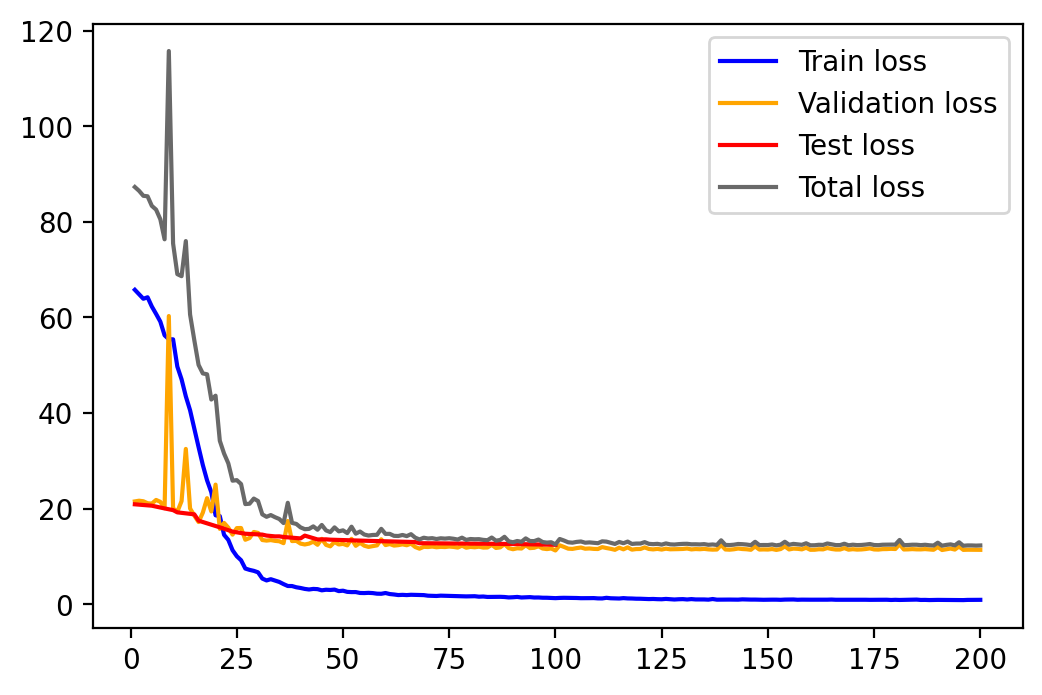

In [8]:
print("Train Loss: {:.4f} | Valid Loss: {:.4f} | Test Loss on Best Model: {:.4f}".format(besttrloss, bestvalloss, besttsloss))
plt.plot(ep,trainloss,color='blue', label = 'Train loss')
plt.plot(ep, validloss, color = 'orange',label = 'Validation loss')
plt.plot(testep, testloss, color = 'red',label = 'Test loss')
plt.plot(ep, totloss, color = 'dimgray',label = 'Total loss')
plt.legend()
plt.show()

In [9]:
tsloss = 0
model.load_state_dict(torch.load('state_cnn_ts3_2.pt'))
model.eval()
with torch.no_grad():
    for batch_idx, (data, targets, _) in enumerate(test_loader):
        data = Variable(data).to(device)
        targets = Variable(targets.view(targets.shape[0],-1)).to(device)

        
        scores = model(data)
        loss = criterion(scores, targets)

        if batch_idx == 0:
            true_scores = targets.cpu().numpy()
            pred_scores = scores.cpu().numpy()
        else:
            true_scores = np.append(true_scores, targets.cpu().numpy(), axis = 0)
            pred_scores = np.append(pred_scores, scores.cpu().numpy(), axis = 0)


        tsloss += loss.item()


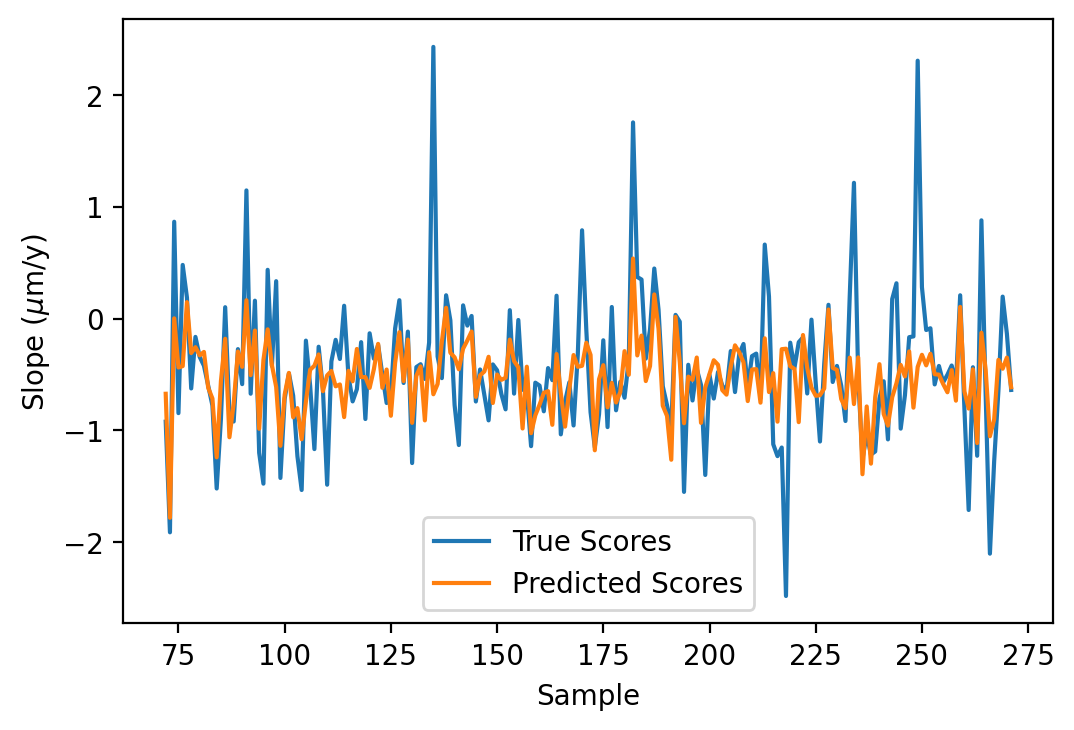

In [10]:
idx = np.array([i+1 for i in range(len(true_scores))])
size = 200
r = np.random.randint(len(idx)-size)
plt.plot(idx[r:r+size], true_scores[r:r+size], label = "True Scores")
plt.plot(idx[r:r+size], pred_scores[r:r+size],label = "Predicted Scores")
plt.ylabel('Slope ($\mu$m/y)')
plt.xlabel('Sample')
plt.legend()
plt.show()

<AxesSubplot:xlabel='Slope ($\\mu$m/y)', ylabel='Count'>

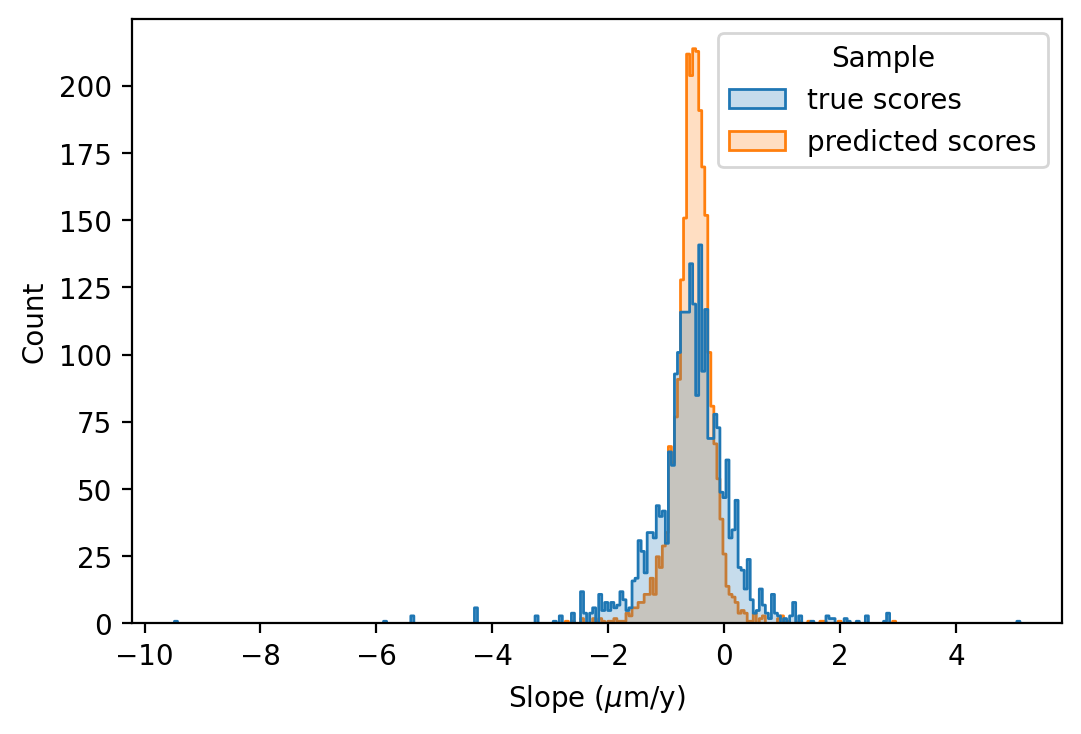

In [11]:
from scipy.stats import ks_2samp
dfx = pd.DataFrame.from_dict({'Slope ($\mu$m/y)': true_scores.ravel().tolist(), 'Sample':'true scores'})
dfy = pd.DataFrame.from_dict({'Slope ($\mu$m/y)': pred_scores.ravel().tolist(), 'Sample':'predicted scores'})
df = pd.concat(axis=0, ignore_index=True, objs=[dfx,dfy])



fig,ax = plt.subplots()
sns.histplot(df,x='Slope ($\mu$m/y)',hue='Sample',ax=ax, element='step')


In [12]:
print(ks_2samp(true_scores.ravel().tolist(),pred_scores.ravel().tolist()))

KstestResult(statistic=0.1349052957093158, pvalue=6.238922911477125e-21)


In [13]:
df.to_csv('predscores.csv')

In [14]:
ndf = pd.DataFrame({'ep': ep,
'train': trainloss,
'valid': validloss,'total':totloss})
ndf.to_csv('losses.csv')

ndf = pd.DataFrame({'ep': testep, 'test':testloss})
ndf.to_csv('testl.csv')

In [15]:
import pandas as pd
import numpy as np

In [16]:
df = pd.read_csv('predscores.csv')

In [17]:
true = np.array(df[df['Sample'] == 'true scores']['Slope ($\mu$m/y)'].tolist())

In [18]:
pred = np.array(df[df['Sample'] == 'predicted scores']['Slope ($\mu$m/y)'].tolist())

In [19]:
from sklearn.metrics import r2_score

coefficient_of_dermination = r2_score(true, pred)

In [20]:
coefficient_of_dermination

0.405975957297512

In [21]:
import scipy
def rsquared(x, y):

    """ Return R^2 where x and y are array-like."""

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return r_value**2

In [22]:
rsquared(true, pred)

0.4309946139503956

In [23]:
scipy.stats.spearmanr(true, pred)

SpearmanrResult(correlation=0.6376528631099307, pvalue=2.7632898470172364e-295)

In [24]:
scipy.stats.pearsonr(true, pred)

(0.6565018004167206, 7.34735e-319)